### Feature Importance with substitution effects

It is useful to distinguish between methods for estimating feature importance based on whether they are influenced by substitution effects. In this context, substitution effects occur when the estimated feature importance is reduced by the presence of other related features. The substitution effect in Machine Learning is similar to what is called Multicollinearity in the context of statistics or econometrics. One way to deal with the linear substitution effect is to apply PCA to the original features and then perform feature importance analysis on the orthogonal features.

#### $p-\mathrm{value}$

Classical regression frameworks make several assumptions about the fitted model, such as correct model specification, uncorrelated regressors, or white noise residuals. Assuming that such an assumption is true, researchers have tried to determine the importance of explanatory variables through hypothesis testing. A common way to express the importance and explanatory power of a variable is the p-value, a concept proposed in the 1700s.

$$p-\mathrm{value} = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}$$

The p-value quantifies the probability that we would have obtained the same or more extreme results as we estimated when the actual coefficient associated with that variable was 0. This indicates how inconsistent the data is with the established statistical model. However, p-value does not measure the probability that the null or alternative hypothesis is not true or that the data are random. Additionally, the misuse of p-values ​​is not only widespread, but also raises credibility issues in financial research over the past few decades.

In fact, the biggest disadvantage of the p-value is that its basis relies on very strong assumptions. When even one of those assumptions is wrong, the likelihood of false positives and false negatives increases. For this reason, the American Statistical Association does not recommend the application of p-value as a measure of statistical significance in 2019 (Wasserstein et al. 2019)

The second drawback of p-value is that p-value cannot be robustly estimated for variables with high multicollinearity. In situations where multicollinearity exists, traditional regression analysis methods cannot distinguish between redundant information, so a substitution effect between p-values ​​may occur, resulting in results that are inflated compared to the actual value.

A third drawback of the p-value is that it evaluates completely unrelated probabilities. Given the null hypothesis $H_0$ and the estimated coefficient $\hat{\beta}$, the p-value estimates the probability of obtaining an extreme result equal to or extreme than $\hat{\beta}$ if $H_0$ is true. However, researchers are often more interested in another probability, namely the probability that $H_0$ is true given $\hat{\beta}$. This probability can be calculated using Bayes theorem, and can only be obtained by making assumptions about the surrounding distribution.

The fourth flaw of p-value is that it assesses the significance of samples. The entire sample is used to solve two tasks: estimating coefficients and determining significance. Therefore, p-values ​​can be low for variables that have no out-of-sample explanatory value. Running multiple in-sample tests on the same dataset increases the chance of making false discoveries, which is statistical fraud.

In summary, p-value is not suitable for models with multiple variables because it requires too many assumptions than necessary, and is also an inappropriate value for estimating significance. Let’s look at the example below to see how p-value dilutes information.

The following function is a function that generates informative, redundant, and noise features. Each feature has the following characteristics:

1. Informative: A feature that actually provides the most unique and independent information in label prediction.
2. Redundant: A feature that provides important information in label prediction, but has multicollinearity between features.
3. Noise: A feature that has almost no effect on label prediction.

In [4]:
# Setup path to import FinancialMachineLearning modules
import sys
from pathlib import Path

# Add the MLFinance root directory to Python path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # Go up from Notes/Week05Labeling to MLFinance
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✓ Added {project_root} to Python path")

✓ Added /mnt/ssd_backup/equity-ml-ldp/MLFinance to Python path


In [5]:
import pandas as pd
import numpy as np
from FinancialMachineLearning.generator.classification_data import get_test_data

Total features are specified as 20, informative features as 5, and redundant features as 5. Noise automatically becomes 10. The number of observations is generated as 1000.

In [6]:
trnsX, cont = get_test_data(
    n_features = 20, 
    n_informative = 5, 
    n_redundant = 5, 
    n_samples = 1000
)

In [7]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

ols = sm.Logit(cont['bin'], trnsX).fit()

         Current function value: 0.438438
         Iterations: 35


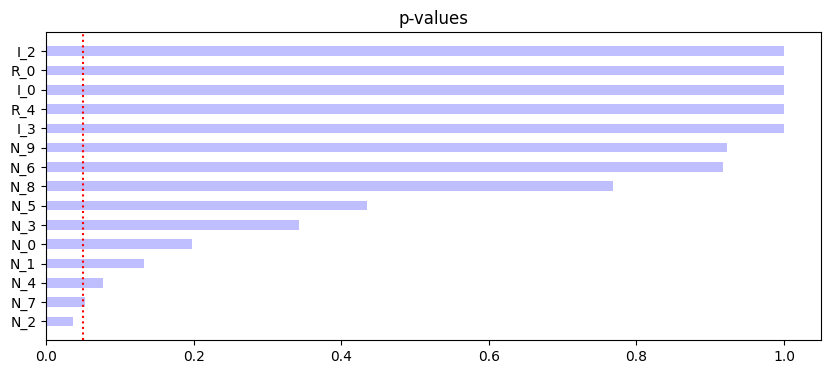

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending = True).index, 
    ols.pvalues.sort_values(ascending = True), 
    color = 'b', alpha = 0.25, height = 0.5
)
plt.axvline(0.05, ls = ':', color = 'r')
plt.grid(False)
plt.title('p-values')
plt.show()

Unfortunately, financial datasets are often highly multicollinear as a result of common risk factors shared by many parts of the investment environment, including markets, sectors, ratings, value, momentum, earnings quality, and duration. In this situation, financial researchers should stop relying solely on p-values. It is important for financial researchers to be familiar with additional methods for determining which variables contain information about a particular phenomenon.

#### Mean Decrease Importance

Suppose we have training samples of size N, consisting of F features and one label per observation. The classification/regression algorithm based on the Tree Model splits the label in each note $t$ into two samples. For a given feature $X_f$, the labels of nodes $t$ associated with $X_f$ below a certain threshold $\tau$ are placed in the left sample, and the rest are placed in the right sample. This is called branching, and most ensemble models such as Tree-based Random Forest, XG Boost, and Cat Boost go through this branching process.

For each sample, impurity can be evaluated according to the entropy of the label value distribution, Gini impurity, or other criteria. Intuitively, a sample is purest when it contains only one type of label, and impurity is highest when the labels follow a uniform distribution. The information gain obtained by segmentation is measured by the reduction in impurity as follows:

$$\Delta g(t, f) = i(t) - \frac{N_t^{(0)}}{N_t}i(t^{(0)}) - \frac{N_t^{(1)}}{N_t}i(t^{(1)})$$

Here, $i(t)$ is the impurity of the label at node $t$, $i(t^{(0)})$ is the impurity of the sample branched to the left, and $i(t^{(1)})$ is the impurity of the sample branched to the right.

At each node $t$, the classification model evaluates $\Delta g(t, f)$ for various features of $\{X_f\}_{1, \dots, F}$, determines the optimal threshold $t$ that maximizes $\Delta g(t, f)$ for each of them, and Select the feature associated with $\Delta g(t, f)$. The classification algorithm branches samples until an early termination condition is met, such as no more information gain or impurity below the maximum acceptable limit.

Feature Importance can be calculated as Weighted Information Gain at all nodes where a feature is selected. Mean Decrease Impurity is an indicator that shows how much a feature contributes to reducing impurity, and the sum of the importance of all features is calculated as 1. If there are $F$ features with equal information, the importance of each feature is expected to be $\frac{1}{F}$.

There are a few things to keep in mind when working with MDI.

1. A mask effect occurs when a tree-based classifier favors certain features and systematically ignores other features. To overcome this, you must set `max_features = 1` when using `RandomForestClassifier` of `sklearn`. Using this approach, we ensure that only one random quirk is considered per level.
    - Provides opportunity to reduce impurity for all features
    - Features with an importance of 0 should not be included in the average calculation. The only reason it is 0 is because the feature was not randomly selected. These values ​​should be replaced with `numpy.nan`, etc.
2. The procedure is clearly In sample. All characteristics have some importance, even if they are not predictive.
3. MDI does not generalize to other classifiers other than tree-based.
4. In terms of structure, MDI has good characteristics in that the sum of feature importance is 1, and the importance of all features has a value between 0 and 1.
5. This method does not address substitution effects when correlated features exist. MDI dilutes the importance of alternative characteristics because of their fungibility. Additionally, the importance of the same two features is reduced by half, since both can be selected randomly with equal probability.
6. Strobl et al. (2007) experimentally showed which predictors MDI is biased by. White & Liu (1994) argued that in the case of a single decision tree, this bias is due to the fact that the famous impurity function unfairly favors predictors with many categories.

Ensemble models such as Random Forest in sklearn are basically equipped with a method to estimate MDI feature importance in the following way.

```
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
```

The importance estimate corresponds to the beta (coefficient) estimate of the econometric model, and std is similar to estimating the t-distribution of a variable. In other words, feature importance can act as a parameter.

Meanwhile, since we are dealing with a time series model, we use feature importance that removes duplication of temporal information as follows.

In [9]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from FinancialMachineLearning.feature_importance import *

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [10]:
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold, cross_val_score
cv_gen = PurgedKFold(
    n_splits = 5, 
    samples_info_sets = cont['t1']
)

In [11]:
oos_score = cross_val_score(
    forest, # base classifier
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

In [12]:
from FinancialMachineLearning.feature_importance.importance import *
mdi = mean_decrease_impurity(fit, trnsX.columns)

In [13]:
mdi.head()

,mean,std
I_0,0.109971,0.003659
I_1,0.042910,0.000926
I_2,0.044977,0.001045
I_3,0.078038,0.002625
I_4,0.055409,0.001246


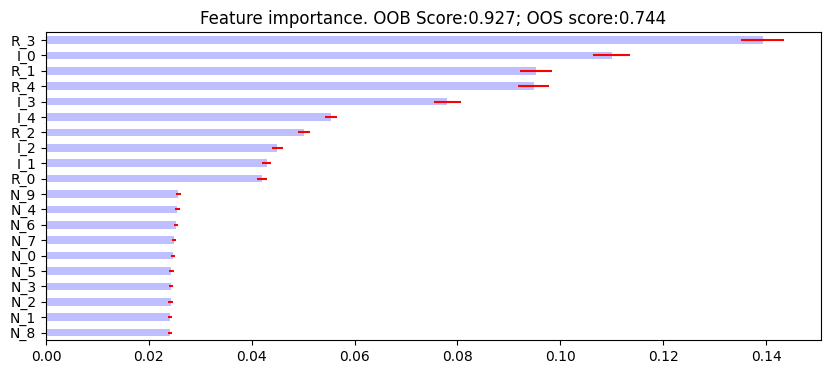

In [14]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

p-value의 결과와 비교해 봤을때, Noise가 모두 하위에 랭크된 것을 볼 수 있다. 모델 학습에 있어서 정보를 가지고 있는 information과 redundant feature들이 중요도가 높게 나온 것을 알 수 있다

MDI feature importance는 다음과 같은 장점이 존재한다

1. MDI는 계산하는 데 있어서 변수의 강력한 분포적 가정을 요구하지 않는다. 즉, 변수의 분포는 어떤 모양을 해도 상관없다
2. 통계모형의 beta는 단일 샘플에 대해 추정되는 반면, ensemble모형의 MDI feature importance는 Bootstrapping을 통해 도출된다. 따라서, 추정치의 분산은 ensemble추정기의 개수를 증가시킴으로써 줄일 수 있다
3. Base Model이 Tree인 분류기의 목적은 주어진 대수 방정식의 계수를 추정하는 것이 아니므로 특정 귀무가설의 확률을 추정하는 것과는 무관하다. 따라서, 추정기에서 실질적으로 도움이 된 특성을 찾아 점수를 매겨준다

다만, MDI는 어디까지나 sample내에서 계산된다는 점에서 과적합의 여지가 존재한다. 이후 소개하는 **MDA feature importance**는 이러한 단점을 보완해 준다

#### Mean Decrease Accuracy

p-value와 MDI 모두 설명 목적으로 샘플 내에서 유의적으로 보이는 변수가 예측의 목적과 무관할 수 있다는 점이다. 이 문제를 해결하고자, MDA 특성 중요도가 제안되었다

MDA는 다음과 같이 동작한다. 
1. 모델을 적합화시키고 교차 검증된 성과를 계산한다
2. 동일한 적합화 모델읠 교차 검증된 성과를 하는데, 단 하나의 차이점은 feature 중 하나와 관련된 관찰값들을 셔플링한다는 것이다. 그것은 특성당 하나의 수정된 교차검증 성능을 제공한다
3. 셔플링 전후의 교차 검증된 성능을 비교함으로써, 특정 feature와 연관된 MDA score를 도출한다. **특성이 중요하다면 특성이 독립인 경우, 셔플링으로 인해 성과의 현저한 저하 현성이 있어야 한다**

MDA의 중요한 속성은 MDI와 마찬가지로 단일 추정치의 결과가 아닌 여러개의 추정치의 평균이라는 것이다. 일반적으로, MDA feature importance는 **순열 중요도 (permutation importance)** 로 많이 불리며, 다음과 같이 구현된다

```
from sklearn.inspection import permutation_importance
r = permutation_importance(
    model, X_val, y_val,
    n_repeats=30,
    random_state=0
)
```

우리는 시간의 순서가 중요한 시계열 데이터를 다루고 있으므로 permutation importance를 그대로 쓰는것 보다는 아래 예제의 MDA 특성 중요도를 사용하도록 하자

한가지 중요한 점은, feature가 독립적이지 않은 경우 MDA는 상호 관련 특성의 중요성을 과소평가할 수 있다. 극단적으로, 매우 중요하지만 동일한 두가지 feature를 고려할 때, MDA는 한 가지 feature를 셔플링하는 효과가 동인한 다른 feature의 존재로 인해 상쇄될 수 있기 때문에, 두 feature모두 중요하지 않다고 결론내릴 수 있다.아래의 예시를 보고, 이러한 점을 확인해 보자

In [11]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [12]:
mda = mean_decrease_accuracy(
    fit, # base classification model
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

5it [00:10,  2.12s/it]


In [13]:
mda.head()

,mean,std
I_0,0.132141,0.228427
I_1,0.104274,0.027225
I_2,0.111496,0.051622
I_3,0.142856,0.065140
I_4,0.133888,0.048109


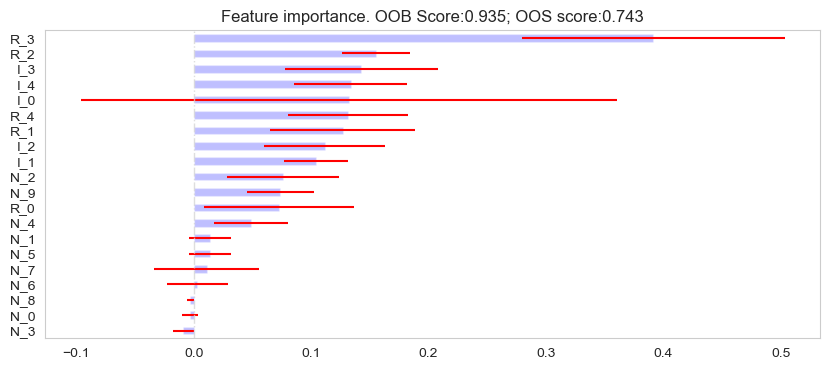

In [14]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

### Feature Importance without substitution effects

대체 효과는 중복되어 있는 중요한 특성을 버리는 결과를 초래할 수 있다. 예측에 있어서는 일반적으로 문제가 되지 않지만, 모델의 이해, 개선, 단순화 과정에서는 잘못된 결론을 이끌 수 있다. 이런 이유로 다음의 Single Feature Importance 기법은 MDI와 MDA의 보완 역할을 할 수 있다.

#### Single Feature Importance

Single Feature Importance는 횡단면 예측 중요도 방법이다. 이 방법은 각 특성에 대해서 독립적으로 out of sample 성과를 계산한다. 몇 가지 고려사항은 다음과 같다.

1. 이 방법은 Tree model 기반의 Ensemble 뿐만 아니라 모든 분류기에 적용할 수 있다.
2. SFI는 성과 점수로서 정확도에만 사용되지 않는다.
3. MDI나 MDA와 달리 대체 효과는 존재하지 않는다. 이유는 한 번에 하나의 특성만 고려하기 때문이다.
4. MDA와 같이 모든 특성이 중요하지 않다는 결론을 내릴 수도 있다. 이유는 성과를 out of sample cross validation을 통해 평가하기 때문이다

SFI의 주요 한계는 2개의 특성을 가진 한개의 분류기가 단일 특성을 가진 2개의 분류기의 bagging보다 더 좋은 성과를 발휘할 수 있다는 점이다. 예를 들어, 특성 B가 특성 A와 있을 때에만 유용하거나, 특성 B 혼자로는 정확하지 않아도 특성 A로부터의 분할을 설명하는 데 유용할 수 있다. 다시 말해서 결합 효과나 계층적 중요도는 SFI에서는 모두 사라진다.

대안 중 하나는 특성의 부분 집합으로부터 Out of sample 성과를 계산하는 것 이지만, 고려해야 할 특성 주가 증가하면 다루기 힘들어진다. 아래의 코드는 SFI 기법 구현 하나를 보여 준다.

In [15]:
sfi = single_feature_importance(
    fit, # base classification model
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

100%|██████████| 20/20 [02:10<00:00,  6.55s/it]


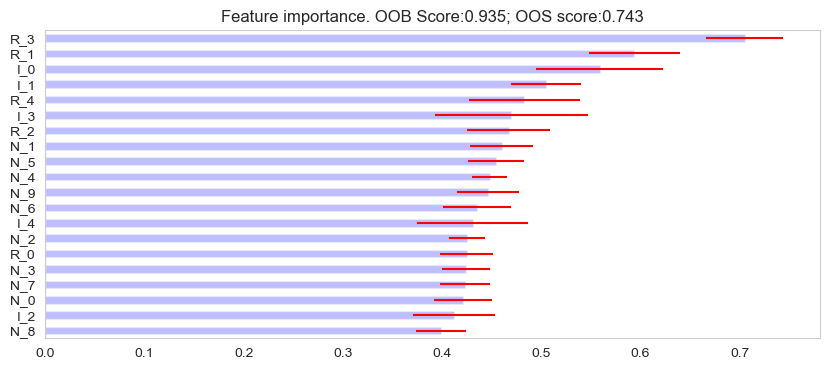

In [16]:
plot_feature_importance(
    sfi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/SFI_feature_importance.png'
)
plt.grid(False)
plt.show()

#### Orthogonal Importance

대체 효과는 MDI로 특정된 feature importance를 희석 시키고, MDA로 측정된 feature importance를 상당히 과소 평가한다. 부분적인 해법은 MDI나 MDA를 적용하기 전에 특성을 직교시키는 것이다. PCA와 같은 직교화 절차는 모든 대체 효과를 방지하지 못하지만, 적어도 선형 대체 효과의 영향은 완화시킨다.

In [37]:
from FinancialMachineLearning.feature_importance.orthogonal import get_orthogonal_features, get_pca_rank_weighted_kendall_tau

ortho_features = get_orthogonal_features(trnsX, variance_thresh = 0.95)
ortho_features = pd.DataFrame(ortho_features, index = trnsX.index)

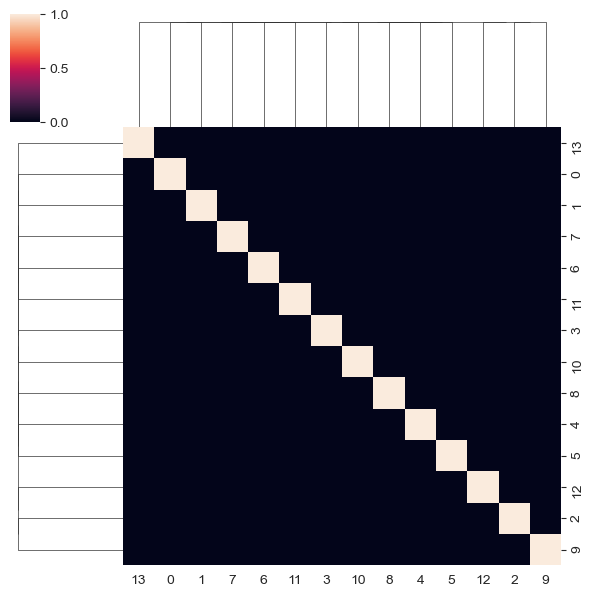

In [28]:
import seaborn as sns
sns.clustermap(pd.DataFrame(ortho_features).corr(), figsize = (6, 6))
plt.show()

In [32]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = ortho_features, y = cont['bin'])

In [38]:
cv_gen = PurgedKFold(
    n_splits = 5, 
    samples_info_sets = cont['t1']
)

In [39]:
oos_score = cross_val_score(
    forest, # base classifier
    ortho_features, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

In [42]:
ortho_mdi = mean_decrease_impurity(
    fit, # base classification model
    ortho_features.columns,
)

In [47]:
ortho_mdi.head()

,mean,std
0,0.123077,0.001958
1,0.232417,0.003438
2,0.091112,0.001231
3,0.051225,0.000672
4,0.049399,0.000647


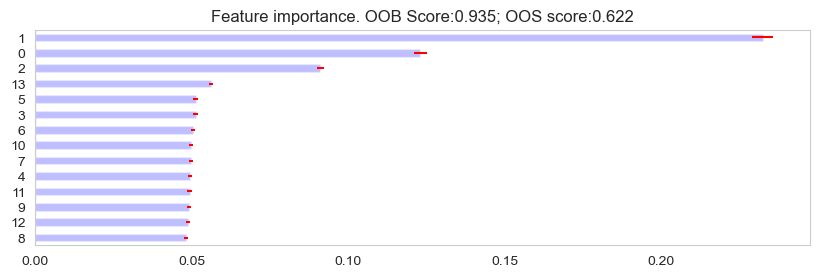

In [48]:
plot_feature_importance(
    ortho_mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/Ortho_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

In [49]:
from FinancialMachineLearning.feature_importance.orthogonal import feature_pca_analysis

pca_mdi = feature_pca_analysis(
    ortho_features, 
    feature_importance = ortho_mdi,
    variance_thresh = 0.95
)

In [50]:
pca_mdi

{'Pearson': PearsonRResult(statistic=0.05265772290001818, pvalue=0.46355755972757967),
 'Spearman': SignificanceResult(statistic=0.1380204078609633, pvalue=0.053709865837689594),
 'Kendall': SignificanceResult(statistic=0.09772182062086067, pvalue=0.04880014677509788),
 'Weighted_Kendall_Rank': SignificanceResult(statistic=0.30025828278416544, pvalue=nan)}

In [51]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = ortho_features, y = cont['bin'])

In [52]:
oos_score = cross_val_score(
    forest, # base classifier
    ortho_features, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

In [53]:
ortho_mda = mean_decrease_impurity(
    fit, # base classification model
    ortho_features.columns,
)

In [54]:
ortho_mda.head()

,mean,std
0,0.163280,0.001933
1,0.342852,0.002619
2,0.118603,0.001204
3,0.034821,0.000585
4,0.029213,0.000544


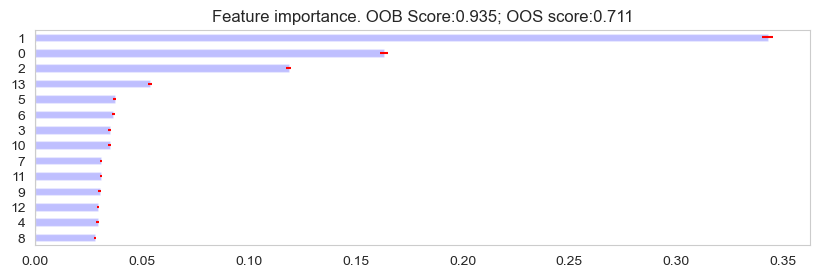

In [55]:
plot_feature_importance(
    ortho_mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/Ortho_MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

In [56]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = ortho_features, y = cont['bin'])

In [58]:
ortho_sfi = single_feature_importance(
    fit, # base classification model
    ortho_features, # train features
    cont['bin'], # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

100%|██████████| 14/14 [01:31<00:00,  6.56s/it]


In [59]:
ortho_sfi.head()

,mean,std
0,0.466,0.033178
1,0.627,0.046143
2,0.483,0.071114
3,0.443,0.023858
4,0.437,0.031324


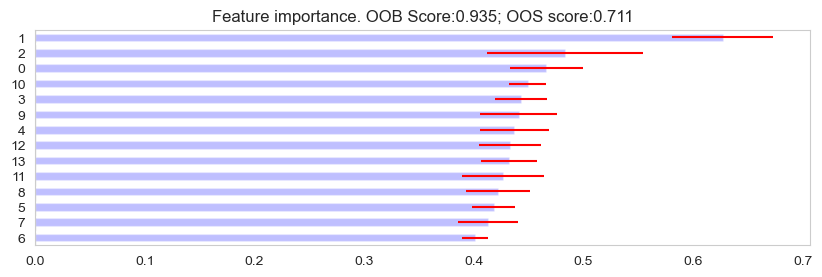

In [60]:
plot_feature_importance(
    ortho_sfi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './images/Ortho_SFI_feature_importance.png'
)
plt.grid(False)
plt.show()